# Solar Power Generation Trends

## Overview

<style>
    table.custom-table {
        max-width: 600px;
        width: 100%;
        margin: 0 auto; /* centers the table on the page */
    }

    table.custom-table td {
        background-color: #fff;
    }
    
    table.custom-table th, table.custom-table td {
        text-align: center;
        vertical-align: middle;
        padding: 5px;
        width: 600px; /* distribute the total width equally among three columns */
    }

    table.custom-table img {
        width: 100%;
        display: block; /* removes any gap under the image */
    }
</style>


<table class="custom-table">
    <thead>
        <tr>
            <th>Additive vs Multiplicative Model</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>
                <img src="src/04_output_1.png">
            </td>
        </tr>
        <tr>
            <td>
                <img src="src/04_output_2.png">
            </td>
        </tr>
    </tbody>
</table>

## Data

In [1]:
import pandas as pd

df = pd.read_csv('../../../data/solar_2014-2023.csv', index_col=0)
df.index = pd.to_datetime(df.index, utc=True)
df = df.tz_convert('Europe/Madrid')
df = df.resample('1h').mean()
s_solar = df.loc[:'2022', 'Solar fotovoltaica']
s_solar_monthly = s_solar.resample('M').sum()
s_solar

/var/folders/89/hqh4vvhn24q2xc8ph93krqz80000gn/T/ipykernel_34582/3102929116.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  s_solar_monthly = s_solar.resample('M').sum()


datetime_utc
2014-01-01 00:00:00+01:00    13.6
2014-01-01 01:00:00+01:00    13.3
                             ... 
2022-12-31 22:00:00+01:00     1.7
2022-12-31 23:00:00+01:00     1.6
Freq: h, Name: Solar fotovoltaica, Length: 78888, dtype: float64

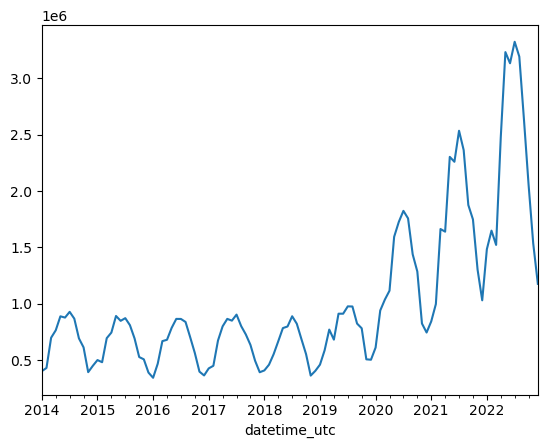

In [2]:
s_solar_monthly.plot.line();

## Multiplicative Model

$y_t = T_t \times S_t \times e_t$

In [3]:
df_solar = s_solar_monthly.to_frame(name='generation')
df_solar

,generation
datetime_utc,
2014-01-31 00:00:00+01:00,402856.200
2014-02-28 00:00:00+01:00,431246.400
...,...
2022-11-30 00:00:00+01:00,1535995.490
2022-12-31 00:00:00+01:00,1176871.031


In [4]:
import statsmodels.api as sm

data = df_solar['generation'].values
result = sm.tsa.seasonal_decompose(data, model='multiplicative', period=12)

df_component = (df_solar
 .assign(
    trend = result.trend,
    seasonal = result.seasonal,
    residual = result.resid)
 .dropna())

df_component['component_all'] = df_component.trend * df_component.seasonal * df_component.residual
df_component

,generation,trend,seasonal,residual,component_all
datetime_utc,,,,,
2014-07-31 00:00:00+02:00,928878.300,6.720014e+05,1.391756,0.993175,928878.300
2014-08-31 00:00:00+02:00,868469.700,6.782240e+05,1.297704,0.986747,868469.700
...,...,...,...,...,...
2022-05-31 00:00:00+02:00,3231541.434,2.262671e+06,1.321597,1.080660,3231541.434
2022-06-30 00:00:00+02:00,3132564.628,2.278476e+06,1.325175,1.037486,3132564.628


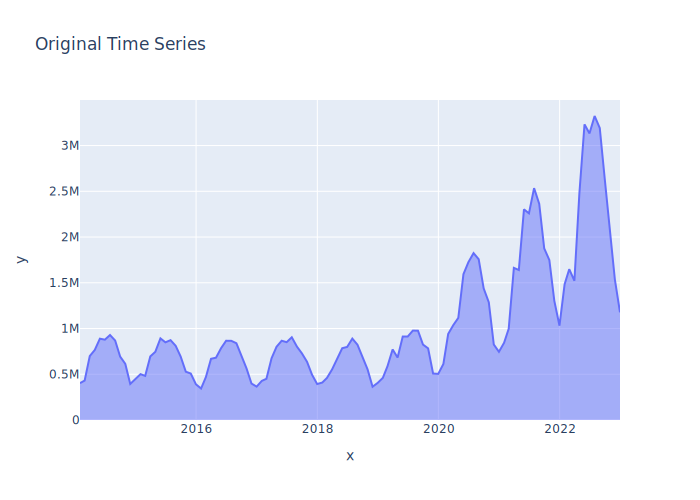

In [5]:
import plotly.express as px

fig = px.area(x=df_solar.index, y=df_solar['generation'], title='Original Time Series')
fig

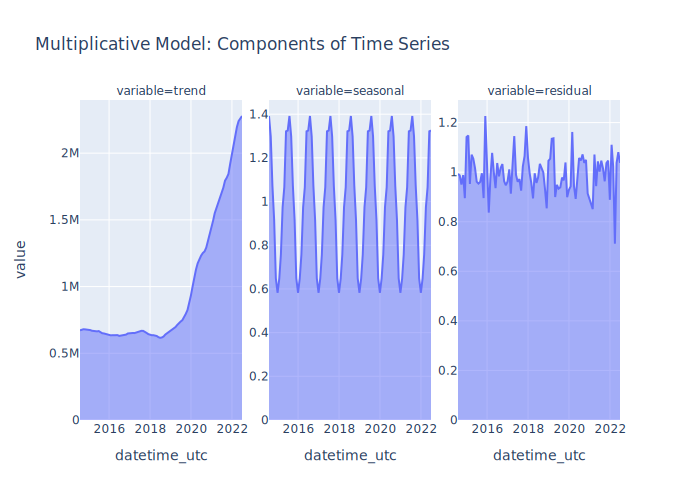

In [6]:
dff = df_component.melt(ignore_index=False)
dff = dff.query('~variable.isin(["generation", "component_all"])')

fig = px.area(dff, x=dff.index, y='value', facet_col='variable', title='Multiplicative Model: Components of Time Series', facet_col_spacing=0.05)
fig = fig.update_yaxes(matches=None)

for axis in fig.layout:
    if 'yaxis' in axis:
        fig.layout[axis].showticklabels = True

fig

## Additive Model

$y_t = T_t + S_t + e_t$

In [8]:
import statsmodels.api as sm

data = df_solar['generation'].values
result = sm.tsa.seasonal_decompose(data, model='additive', period=12)

df_component = (df_solar
 .assign(
    trend = result.trend,
    seasonal = result.seasonal,
    residual = result.resid)
 .dropna())

df_component['component_sum'] = df_component.trend + df_component.seasonal + df_component.residual
df_component

,generation,trend,seasonal,residual,component_sum
datetime_utc,,,,,
2014-07-31 00:00:00+02:00,928878.300,6.720014e+05,353437.131770,-96560.210937,928878.300
2014-08-31 00:00:00+02:00,868469.700,6.782240e+05,271787.442187,-81541.779687,868469.700
...,...,...,...,...,...
2022-05-31 00:00:00+02:00,3231541.434,2.262671e+06,367108.117103,601762.536397,3231541.434
2022-06-30 00:00:00+02:00,3132564.628,2.278476e+06,360459.431348,493628.986110,3132564.628


In [9]:
import plotly.express as px

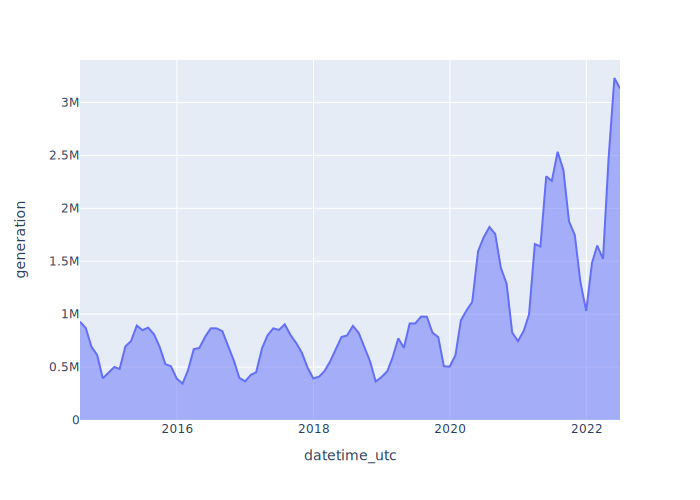

In [10]:
px.area(data_frame=df_component, x=df_component.index, y='generation')

In [11]:
dff = df_component.drop(columns=['generation', 'component_sum'])
dff = dff.melt(ignore_index=False)

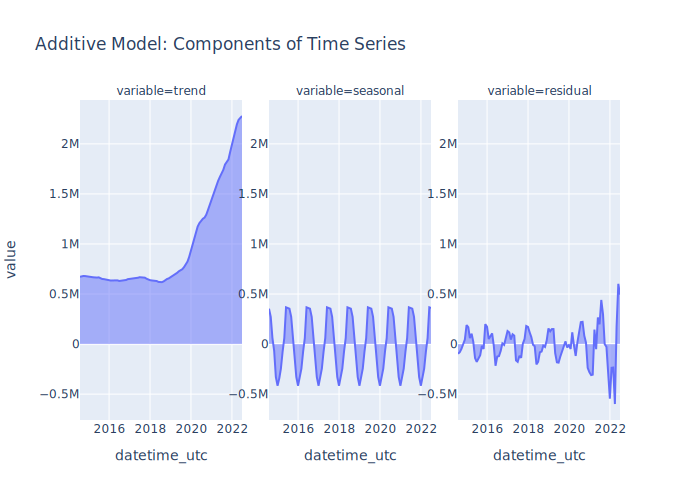

In [12]:
fig = px.area(dff, x=dff.index, y='value', facet_col='variable', title='Additive Model: Components of Time Series', facet_col_spacing=0.05)

for axis in fig.layout:
    if 'yaxis' in axis:
        fig.layout[axis].showticklabels = True
        
fig